In [1]:
import numpy as np
import pandas as pd
import math
import hashlib
import re

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Lasso

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load Working Dataframe

In [2]:
# Load working dataframe
df = pd.read_csv('Datasets/working_df.csv')

df.shape

(86140, 113)

In [3]:
# Drop passwords leaked 100000 times or more
df = df[df['Total'] < 10000]

df.shape

(76581, 113)

# EDA

In [4]:
df['Total'].describe()

count    76581.000000
mean      2461.055040
std       2054.224553
min          0.000000
25%        938.000000
50%       1900.000000
75%       3433.000000
max       9999.000000
Name: Total, dtype: float64

In [5]:
# Create list of features
ignore = ['Password', 'SHA_1', 'Total', 'Length_Sq', 'Length_Cb',
          'Only_Let_Div_Len', 'Only_Dig_Div_Len', 'Only_Spc_Div_Len',
          'Let_And_Dig_Div_Len', 'Let_And_Spc_Div_Len', 'Dig_And_Spc_Div_Len',
          'Date_Div_Len', 'Year_Div_Len', 'Rep_2_Div_Len', 'Rep_3_Div_Len',
          'Rep_4_Div_Len', 'Rep_5_Div_Len', 'Rep_6_Div_Len', 'Rep_7_Div_Len',
          'Rep_8_Div_Len', 'Rep_9_Div_Len', 'Rep_10_Div_Len', 'Asc_Dig_2_Div_Len',
          'Asc_Dig_3_Div_Len', 'Asc_Dig_4_Div_Len', 'Asc_Dig_5_Div_Len', 'Asc_Dig_6_Div_Len',
          'Asc_Dig_7_Div_Len', 'Asc_Dig_8_Div_Len', 'Asc_Dig_9_Div_Len', 'Asc_Dig_10_Div_Len',
          'Dsc_Dig_2_Div_Len', 'Dsc_Dig_3_Div_Len', 'Dsc_Dig_4_Div_Len', 'Dsc_Dig_5_Div_Len',
          'Dsc_Dig_6_Div_Len', 'Dsc_Dig_7_Div_Len', 'Dsc_Dig_8_Div_Len', 'Dsc_Dig_9_Div_Len',
          'Dsc_Dig_10_Div_Len', 'Asc_Let_2_Div_Len', 'Asc_Let_3_Div_Len', 'Asc_Let_4_Div_Len',
          'Asc_Let_5_Div_Len', 'Asc_Let_6_Div_Len', 'Asc_Let_7_Div_Len', 'Asc_Let_8_Div_Len',
          'Asc_Let_9_Div_Len', 'Asc_Let_10_Div_Len', 'Dsc_Let_2_Div_Len', 'Dsc_Let_3_Div_Len',
          'Dsc_Let_4_Div_Len', 'Dsc_Let_5_Div_Len', 'Dsc_Let_6_Div_Len', 'Dsc_Let_7_Div_Len',
          'Dsc_Let_8_Div_Len', 'Dsc_Let_9_Div_Len', 'Dsc_Let_10_Div_Len']
features = df.drop(columns=ignore, axis=1).keys()
features

Index(['Length', 'Length_Pp', 'Only_Let', 'Only_Dig', 'Only_Spc',
       'Let_And_Dig', 'Let_And_Spc', 'Dig_And_Spc', 'Date', 'Year', 'Rep_2',
       'Rep_3', 'Rep_4', 'Rep_5', 'Rep_6', 'Rep_7', 'Rep_8', 'Rep_9', 'Rep_10',
       'Asc_Dig_2', 'Asc_Dig_3', 'Asc_Dig_4', 'Asc_Dig_5', 'Asc_Dig_6',
       'Asc_Dig_7', 'Asc_Dig_8', 'Asc_Dig_9', 'Asc_Dig_10', 'Dsc_Dig_2',
       'Dsc_Dig_3', 'Dsc_Dig_4', 'Dsc_Dig_5', 'Dsc_Dig_6', 'Dsc_Dig_7',
       'Dsc_Dig_8', 'Dsc_Dig_9', 'Dsc_Dig_10', 'Asc_Let_2', 'Asc_Let_3',
       'Asc_Let_4', 'Asc_Let_5', 'Asc_Let_6', 'Asc_Let_7', 'Asc_Let_8',
       'Asc_Let_9', 'Asc_Let_10', 'Dsc_Let_2', 'Dsc_Let_3', 'Dsc_Let_4',
       'Dsc_Let_5', 'Dsc_Let_6', 'Dsc_Let_7', 'Dsc_Let_8', 'Dsc_Let_9',
       'Dsc_Let_10'],
      dtype='object')

In [6]:
# # Create list of features
# ignore = ['Password', 'SHA_1', 'Total']
# features = df.drop(columns=ignore, axis=1).keys()
# features

In [7]:
# # Function to create feature pplots
# def pplot_features(df, features):
#     pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
#     for row in pp_rows:
#         pp = sns.pairplot(data=df, y_vars=['Total'], x_vars=row, kind='reg', height=3)
#     return None

# # Create feature pplots for training df
# pplot_features(df, features)

In [46]:
# Filters for password length and composition
let_dig_spc = (df[df['Only_Let']==0][df['Only_Dig']==0][df['Only_Spc']==0][df['Let_And_Dig']==0]
               [df['Let_And_Spc']==0][df['Dig_And_Spc']==0])

filt_letdig = df['Let_And_Dig'] == 1
filt_letspc = df['Let_And_Spc'] == 1
filt_6 = df['Length'] == 6
filt_7 = df['Length'] == 7
filt_8 = df['Length'] == 8
filt_9 = df['Length'] == 9
filt_10 = df['Length'] == 10
filt_11 = df['Length'] == 11
filt_12 = df['Length'] == 12

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
# # Letter and digit passwords by length
# print(df[filt_letdig][filt_8]['Total'].mean(), df[filt_letdig][filt_9]['Total'].mean(),
#       df[filt_letdig][filt_10]['Total'].mean(), df[filt_letdig][filt_11]['Total'].mean(),
#       df[filt_letdig][filt_12]['Total'].mean())

In [48]:
# # Letter and special character passwords by length
# print(df[filt_letspc][filt_8]['Total'].mean(), df[filt_letspc][filt_9]['Total'].mean(),
#       df[filt_letspc][filt_10]['Total'].mean(), df[filt_letspc][filt_11]['Total'].mean(),
#       df[filt_letspc][filt_12]['Total'].mean())

In [49]:
# # Letter, digit and special character passwords by length
# print(let_dig_spc[filt_8]['Total'].mean(), let_dig_spc[filt_9]['Total'].mean(),
#       let_dig_spc[filt_10]['Total'].mean(), let_dig_spc[filt_11]['Total'].mean(),
#       let_dig_spc[filt_12]['Total'].mean())

In [50]:
# # Filters for repeated characters
# filt_r2 = df['Rep_2'] = 1
# filt_r3 = df['Rep_3'] = 1
# filt_r4 = df['Rep_4'] = 1
# filt_r5 = df['Rep_5'] = 1
# filt_r6 = df['Rep_6'] = 1
# filt_r7 = df['Rep_7'] = 1
# filt_r8 = df['Rep_8'] = 1

# Test/Train Split

In [14]:
# Fucntion to split data into test and train data
def tt_split(df):
    ignore = ['Password', 'SHA_1', 'Total']
    Y = df['Total']
    for col in ignore:
        df = df.drop(columns=col, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(df, Y, random_state=22,test_size=0.2)
    return x_train, x_test, y_train, y_test

# Split training data into test and train data
x_train, x_test, y_train, y_test = tt_split(df)

# Simple Linear Regression

In [15]:
# Simple regression model on training data
model = sm.OLS(y_train, sm.add_constant(x_train[[key for key in x_train]])).fit()
model.summary()

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     38.57
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        10:45:22   Log-Likelihood:            -5.5282e+05
No. Observations:               61264   AIC:                         1.106e+06
Df Residuals:                   61183   BIC:                         1.107e+06
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Length               1266.9433    855.772      1.480      0.139    -410.373    2944.259
Length_Sq             -30.4948     60.311     -0.506      0.613    -148.705      87.716
Length_Cb              -0.4165      1.546     -0.269      0.788      -3.447       2.614
Length_Pp              63.3472     42.789      1.480      0.139     -20.519     147.213
Only_Let            -3376.8920   1524.744     -2.215      0.027   -6365.394    -388.390
Only_Dig            -6016.6105   1529.553     -3.934      0.000   -9014.539   -3018.682
Only_Spc             9375.2579    2.2e+04      0.426      0.670   -3.38e+04    5.25e+04
Let_And_Dig         -4009.6364   1527.120     -2.626      0.009   -7002.795   -1016.478
Let_And_Spc         -4244.7796   3185.502     -1.333      0.183   -1.05e+04    1998.812
Dig_And_Spc         -1620.4599   4714.120     -0.344      0.731   -1.09e+04    7619.229
Date                 1.479e-10   9.07e-11      1.630      0.103   -2.99e-11    3.26e-10
Year                 -651.3608    860.481     -0.757      0.449   -2337.907    1035.185
Rep_2                -997.5390    550.807     -1.811      0.070   -2077.121      82.043
Rep_3                -997.5390    550.807     -1.811      0.070   -2077.121      82.043
Rep_4                -997.5390    550.807     -1.811      0.070   -2077.121      82.043
Rep_5                -997.5390    550.807     -1.811      0.070   -2077.121      82.043
Rep_6                -997.5390    550.807     -1.811      0.070   -2077.121      82.043
Rep_7                -997.5390    550.807     -1.811      0.070   -2077.121      82.043
Rep_8                -997.5390    550.807     -1.811      0.070   -2077.121      82.043
Rep_9                 147.2886    468.608      0.314      0.753    -771.184    1065.761
Rep_10               2531.0336   3116.060      0.812      0.417   -3576.452    8638.519
Asc_Dig_2            -409.8141    168.244     -2.436      0.015    -739.572     -80.056
Asc_Dig_3             988.9613    387.328      2.553      0.011     229.798    1748.124
Asc_Dig_4             538.9109    983.393      0.548      0.584   -1388.541    2466.363
Asc_Dig_5           -3522.6746   1476.244     -2.386      0.017   -6416.117    -629.232
Asc_Dig_6           -1150.6874   2417.152     -0.476      0.634   -5888.313    3586.938
Asc_Dig_7           -3751.2266   3725.852     -1.007      0.314   -1.11e+04    3551.454
Asc_Dig_8           -1000.9184   4420.118     -0.226      0.821   -9664.362    7662.525
Asc_Dig_9            1.108e+04   3911.441      2.834      0.005    3417.437    1.88e+04
Asc_Dig_10            1.07e+04   5610.340      1.907      0.056    -295.241    2.17e+04
Dsc_Dig_2            1391.3716    171.579      8.109      0.000    1055.076    1727.667
Dsc_Dig_3            1234.3328    390.021      3.165      0.002     469.890    1998.776
Dsc

# Lasso Regression

In [16]:
lasso = Lasso(alpha=0.01, normalize=False)
lasso.fit(x_train, y_train)
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123622191001.72173, tolerance: 25932767.989275213
  positive)


In [17]:
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 1542.7220567069733
Testing Error: 1997.3962788092679


In [18]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = x_train.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T

print(lasso_coef)

     Length_Pp  Dsc_Dig_2_Div_Len  Rep_4_Div_Len    Asc_Let_5  \
0 -9637.508149        -7290.68507   -4969.599532 -4284.017741   

   Dsc_Dig_3_Div_Len  Rep_6_Div_Len    Asc_Dig_5    Dsc_Let_3  Rep_5_Div_Len  \
0       -3533.074352   -3005.217323 -2759.404481 -2136.371915    -1892.64565   

   Asc_Let_2_Div_Len  ...     Only_Spc  Asc_Dig_2_Div_Len   Asc_Dig_10  \
0       -1891.523814  ...  2573.767377        2841.653251  4182.966558   

   Asc_Dig_6_Div_Len  Let_And_Dig_Div_Len  Dsc_Let_3_Div_Len  \
0        6354.384563          8355.036685       14379.618463   

   Only_Dig_Div_Len  Rep_7_Div_Len  Asc_Dig_5_Div_Len  Rep_8_Div_Len  
0      15432.842374   17267.495798       22030.489381   26056.989245  

[1 rows x 110 columns]


# Poisson Regression

In [79]:
# Create poisson dataframe
pois = df.copy(deep=True)

In [80]:
# Create poisson variables
pois_ds = pois.index.to_series()
pois_mask = np.random.rand(len(df)) < 0.8
pois_train = pois[pois_mask]
pois_test = pois[~pois_mask]
print('Training data set length = '+str(len(pois_train)))
print('Testing data set length = '+str(len(pois_test)))

Training data set length = 61160
Testing data set length = 15421


In [81]:
# Create poisson features
ignore = ['Password', 'SHA_1', 'Total', 'Length_Sq', 'Length_Cb',
          'Only_Let_Div_Len', 'Only_Dig_Div_Len', 'Only_Spc_Div_Len',
          'Let_And_Dig_Div_Len', 'Let_And_Spc_Div_Len', 'Dig_And_Spc_Div_Len',
          'Date_Div_Len', 'Year_Div_Len', 'Rep_2_Div_Len', 'Rep_3_Div_Len',
          'Rep_4_Div_Len', 'Rep_5_Div_Len', 'Rep_6_Div_Len', 'Rep_7_Div_Len',
          'Rep_8_Div_Len', 'Rep_9_Div_Len', 'Rep_10_Div_Len', 'Asc_Dig_2_Div_Len',
          'Asc_Dig_3_Div_Len', 'Asc_Dig_4_Div_Len', 'Asc_Dig_5_Div_Len', 'Asc_Dig_6_Div_Len',
          'Asc_Dig_7_Div_Len', 'Asc_Dig_8_Div_Len', 'Asc_Dig_9_Div_Len', 'Asc_Dig_10_Div_Len',
          'Dsc_Dig_2_Div_Len', 'Dsc_Dig_3_Div_Len', 'Dsc_Dig_4_Div_Len', 'Dsc_Dig_5_Div_Len',
          'Dsc_Dig_6_Div_Len', 'Dsc_Dig_7_Div_Len', 'Dsc_Dig_8_Div_Len', 'Dsc_Dig_9_Div_Len',
          'Dsc_Dig_10_Div_Len', 'Asc_Let_2_Div_Len', 'Asc_Let_3_Div_Len', 'Asc_Let_4_Div_Len',
          'Asc_Let_5_Div_Len', 'Asc_Let_6_Div_Len', 'Asc_Let_7_Div_Len', 'Asc_Let_8_Div_Len',
          'Asc_Let_9_Div_Len', 'Asc_Let_10_Div_Len', 'Dsc_Let_2_Div_Len', 'Dsc_Let_3_Div_Len',
          'Dsc_Let_4_Div_Len', 'Dsc_Let_5_Div_Len', 'Dsc_Let_6_Div_Len', 'Dsc_Let_7_Div_Len',
          'Dsc_Let_8_Div_Len', 'Dsc_Let_9_Div_Len', 'Dsc_Let_10_Div_Len']
pois_features = pois.drop(columns=ignore, axis=1).keys()

# Create poisson expression
pois_expr = 'Total~' + '+'.join([f'{f}' for f in pois_features])

In [82]:
# # Create poisson features
# ignore = ['Password', 'SHA_1', 'Total']
# pois_features = pois.drop(columns=ignore, axis=1).keys()

# # Create poisson expression
# pois_expr = 'Total~' + '+'.join([f'{f}' for f in pois_features])

In [83]:
# Create poisson test/train split
pois_y_train, pois_X_train = dmatrices(pois_expr, pois_train, return_type='dataframe')
pois_y_test, pois_X_test = dmatrices(pois_expr, pois_test, return_type='dataframe')

In [87]:
# Print poisson train results
pois_trn_res = sm.GLM(pois_y_train, pois_X_train, family=sm.families.Poisson()).fit()

pois_trn_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                61160
Model:                            GLM   Df Residuals:                    61120
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.7477e+07
Date:                Fri, 08 May 2020   Deviance:                   9.4392e+07
Time:                        11:47:21   Pearson chi2:                 9.86e+07
No. Iterations:                    69                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9710      0.001   1469.306      0.000       0.970       0.972
Length         -0.0427   7.56e-05   -565.298      0.000      -0.043      -0.043
Length_Pp      -0.0021   3.78e-06   -565.298      0.000      -0.002      -0.002
Only_Let        0.3378      0.005     64.350      0.000       0.327       0.348
Only_Dig        0.1670      0.005     31.813      0.000       0.157       0.177
Only_Spc        1.1093      0.015     75.503      0.000       1.080       1.138
Let_And_Dig     0.5551      0.005    105.725      0.000       0.545       0.565
Let_And_Spc     0.6565      0.006    107.655      0.000       0.645       0.668
Dig_And_Spc     0.6519      0.008     84.070      0.000       0.637       0.667
Date         1.262e-15   2.76e-17     45.810      0.000    1.21e-15    1.32e-15
Year           -0.4885      0.001   -394.539      0.000      -0.491      -0.486
Rep_2           0.9710      0.001   1469.306      0.000       0.970       0.972
Rep_3           0.9710      0.001   1469.306      0.000       0.970       0.972
Rep_4           0.9710      0.001   1469.306      0.000       0.970       0.972
Rep_5           0.9710      0.001   1469.306      0.000       0.970       0.972
Rep_6           0.9710      0.001   1469.306      0.000       0.970       0.972
Rep_7           0.9710      0.001   1469.306      0.000       0.970       0.972
Rep_8           0.9710      0.001   1469.306      0.000       0.970       0.972
Rep_9           0.2616      0.004     59.455      0.000       0.253       0.270
Rep_10          0.7928      0.003    255.599      0.000       0.787       0.799
Asc_Dig_2       0.0342      0.000    135.202      0.000       0.034       0.035
Asc_Dig_3       0.2514      0.001    464.167      0.000       0.250       0.253
Asc_Dig_4       0.0569      0.001     43.930      0.000       0.054       0.059
Asc_Dig_5       0.0180      0.002      9.322      0.000       0.014       0.022
Asc_Dig_6       0.1366      0.003     50.094      0.000       0.131       0.142
Asc_Dig_7       0.2898      0.004     82.756      0.000       0.283       0.297
Asc_Dig_8      -0.0914      0.004    -20.474      0.000      -0.100      -0.083
Asc_Dig_9       0.0673      0.004     16.438      0.000       0.059       0.075
Asc_Dig_10      0.8518      0.008    101.997      0.000       0.835       0.868
Dsc_Dig_2       0.0993      0.000    379.622      0.000       0.099       0.100
Dsc_Dig_3       0.1876      0.001    342.977      0.000       0.187       0.189
Dsc_Dig_4       0.0134      0.003      4.257      0.000       0.007       0.020
Dsc_Dig_5       0.2467      0.005     48.480      0.000       0.237       0.257
Dsc_Dig_6      -0.3518      0.010    -33.738      0.000      -0.372      -0.331
Dsc_Dig_7       0.2103      0.012     17.801      0.000       0.187       0.233
Dsc_Dig_8      -0.3768      0.013    -28.05

In [85]:
# Create poisson predictions and predictions dataframe
pois_pred = pois_trn_res.get_prediction(pois_X_test)
pois_pred_df = pois_pred.summary_frame()

pois_pred_df.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
9563,3024.534180,0.947674,3022.677343,3026.392158
9564,2562.327471,0.420130,2561.504163,2563.151043
9570,2454.854860,0.362831,2454.143827,2455.566099
9573,2454.854860,0.362831,2454.143827,2455.566099
9580,2351.890012,0.395627,2351.114724,2352.665555


# Visualizations

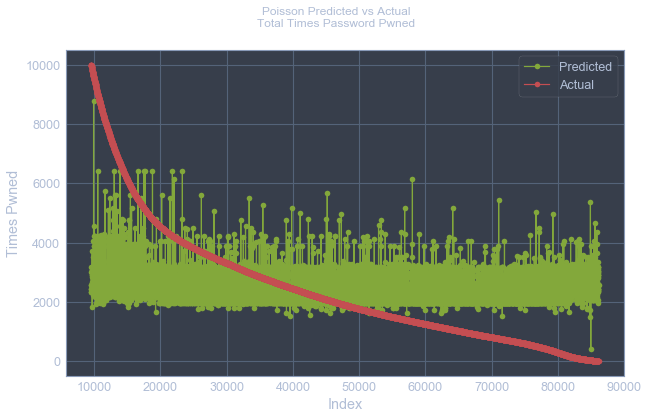

In [91]:
# Create poisson predicted and actual pwned totals to be plotted
pois_pred_cnt = pois_pred_df['mean']
pois_act_cnt = pois_y_test['Total']

# Plot poisson predicted vs actual pwned totals
pois_fig = plt.figure(figsize=(10,6))
pois_fig.suptitle('Poisson Predicted vs Actual\nTotal Times Password Pwned')
pois_pred_plt, = plt.plot(pois_X_test.index, pois_pred_cnt, 'go-', label='Predicted')
pois_act_plt, = plt.plot(pois_X_test.index, pois_act_cnt, 'ro-', label='Actual')
plt.xlabel('Index')
plt.ylabel('Times Pwned')
plt.legend(handles=[pois_pred_plt, pois_act_plt])
plt.show()

In [92]:
# # Save poisson figure
# pois_fig.savefig('Visualizations/poisson.png', dpi=300)

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Times Pwned'),
 Text(0.5, 1.0, 'Distribution: Number of Times\nPasswords Pwned')]

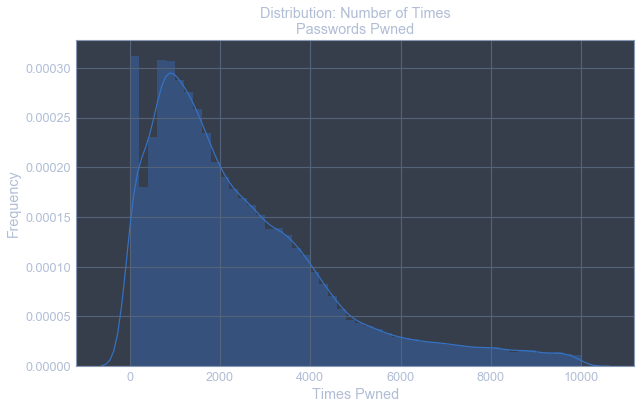

In [116]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(df['Total'])
ax.set(title='Distribution: Number of Times\nPasswords Pwned',
       xlabel='Times Pwned', ylabel='Frequency')

In [117]:
fig.savefig('Visualizations/pwned_dist.png', dpi=300)

Distribution is skewed right.

Text(0, 0.5, 'Times Pwned (Mean)')

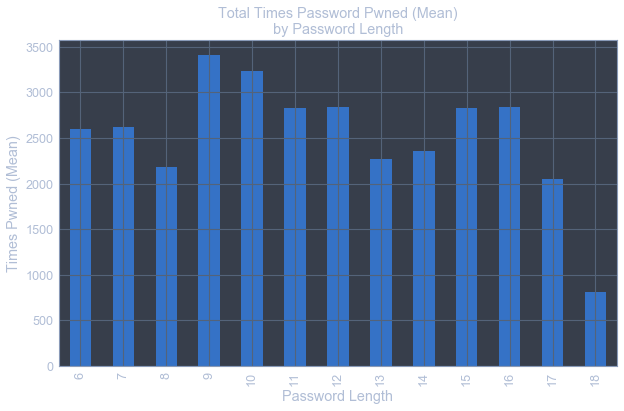

In [97]:
# Plot mean total times pwned by password length
fig, ax = plt.subplots(figsize=(10,6))
ax = df.groupby('Length')['Total'].mean().iloc[:-2].plot(
    kind='bar', title='Total Times Password Pwned (Mean)\nby Password Length')
ax.set_xlabel('Password Length')
ax.set_ylabel('Times Pwned (Mean)')

In [98]:
# # Save figure
# fig.savefig('Visualizations/mean_pwned_by_length', dpi=300)

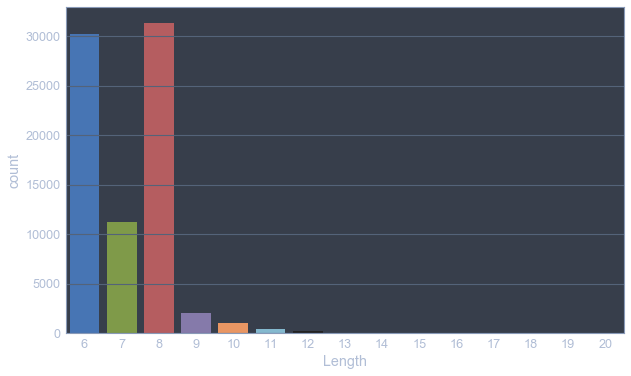

In [107]:
# Plot the distribution of pwned password lengths
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x='Length', data=df)
title='Distribution of Pwned Password Lengths'

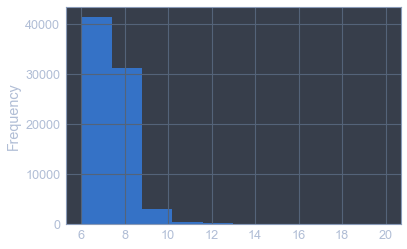

In [27]:
df['Length'].sort_values().plot(kind='hist')

In [59]:
# Plot total pwned by repeated characters
plot_df = df.copy(deep=True)
plot_cond = [plot_df['Rep_2']==1, plot_df['Rep_3']==1, plot_df['Rep_4']==1,
                   plot_df['Rep_5']==1, plot_df['Rep_6']==1, plot_df['Rep_7']==1,
                   plot_df['Rep_8']==1]
plot_chce = ['Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight']
plot_df['Plot'] = np.select(plot_cond, plot_chce, 'Other')

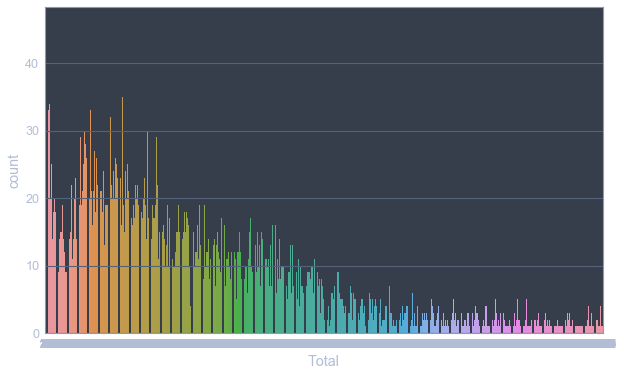

In [61]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x='Total', data=plot_df)
plt.show()

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
# sns.set_context('notebook')
ax = sns.countplot(x="channels", data=dropped_news, palette='Set1')
plt.title('Number of Shares per Article Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Shares')

SyntaxError: invalid syntax (<ipython-input-60-abf1e7847fd0>, line 3)

9559     Two
9560     Two
9561     Two
9562     Two
9563     Two
9564     Two
9565     Two
9566     Two
9567     Two
9568     Two
9569     Two
9570     Two
9571     Two
9572     Two
9573     Two
9574     Two
9575     Two
9576     Two
9577     Two
9578     Two
9579     Two
9580     Two
9581     Two
9582     Two
9583     Two
9584     Two
9585     Two
9586     Two
9587     Two
9588     Two
        ... 
86110    Two
86111    Two
86112    Two
86113    Two
86114    Two
86115    Two
86116    Two
86117    Two
86118    Two
86119    Two
86120    Two
86121    Two
86122    Two
86123    Two
86124    Two
86125    Two
86126    Two
86127    Two
86128    Two
86129    Two
86130    Two
86131    Two
86132    Two
86133    Two
86134    Two
86135    Two
86136    Two
86137    Two
86138    Two
86139    Two
Name: channels, Length: 76581, dtype: object